## Intrinsic calibration results plots

In [39]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()
src_path = f"{root}/src"
if src_path not in sys.path:
    sys.path.append(src_path)


In [40]:
base_folder = f"{root}/images/STEREOS"
output_path = f"{root}/data/intrinsic_experiments.csv"
chessboard_size = (9, 6)
square_size_mm = 60

In [42]:
from calibrate_intrinsic import calibrate_camera_from_folder
from itertools import product

experiments = [
    {'threshold': 0, 'win_size': (15, 15)},
    {'threshold': 0, 'win_size': (7, 7)},
    {'threshold': 0, 'win_size': (5, 5)},

    {'threshold': 0.08, 'win_size': (15, 15)},
    {'threshold': 0.08, 'win_size': (7, 7)},
    {'threshold': 0.08, 'win_size': (5, 5)},

    {'threshold': 0.06, 'win_size': (15, 15)},
    {'threshold': 0.06, 'win_size': (7, 7)},
    {'threshold': 0.06, 'win_size': (5, 5)},

    {'threshold': 0.04, 'win_size': (15, 15)},
    {'threshold': 0.04, 'win_size': (7, 7)},
    {'threshold': 0.04, 'win_size': (5, 5)}
]


results = []
for exp in experiments:
  cameras = {
      "CAM_1": os.path.join(base_folder, "STEREO_A/CAMERA_1", "intrinsic_frames"),
      "CAM_2": os.path.join(base_folder, "STEREO_A/CAMERA_2", "intrinsic_frames"),
      "CAM_3": os.path.join(base_folder, "STEREO_B/CAMERA_3", "intrinsic_frames"),
      "CAM_4": os.path.join(base_folder, "STEREO_B/CAMERA_4", "intrinsic_frames"),
  }
  for cam_name, folder in cameras.items():
        try:
            K, D, error, count_before, count_after, NEW_K, roi = calibrate_camera_from_folder(
                folder,
                chessboard_size,
                square_size_mm,
                threshold=exp['threshold'],
                windSize=exp['win_size'],
                with_flags=True,
                apply_filtering=False if exp['threshold'] == 0 else True,
                debug_mode=False
            )
            
            # Store only the main metrics
            result = {
                'camera': cam_name,
                'threshold': exp['threshold'],
                'win_size': exp['win_size'][0],
                'frames_before': count_before,
                'frames_after': count_after,
                'error': round(error, 2)
            }
            results.append(result)
            
        except Exception as e:
            print(f"Error with camera {cam_name}: {e}")
            continue

df = pd.DataFrame(results)
df.to_csv(output_path, index=False)

Error with camera CAM_1: Not enough images after filtering; using initial calibration error
Error with camera CAM_2: Not enough images after filtering; using initial calibration error
Error with camera CAM_3: Not enough images after filtering; using initial calibration error
Error with camera CAM_4: Not enough images after filtering; using initial calibration error
Error with camera CAM_1: Not enough images after filtering; using initial calibration error
Error with camera CAM_2: Not enough images after filtering; using initial calibration error
Error with camera CAM_3: Not enough images after filtering; using initial calibration error
Error with camera CAM_4: Not enough images after filtering; using initial calibration error
Error with camera CAM_1: Not enough images after filtering; using initial calibration error
Error with camera CAM_2: Not enough images after filtering; using initial calibration error
Error with camera CAM_3: Not enough images after filtering; using initial calibr

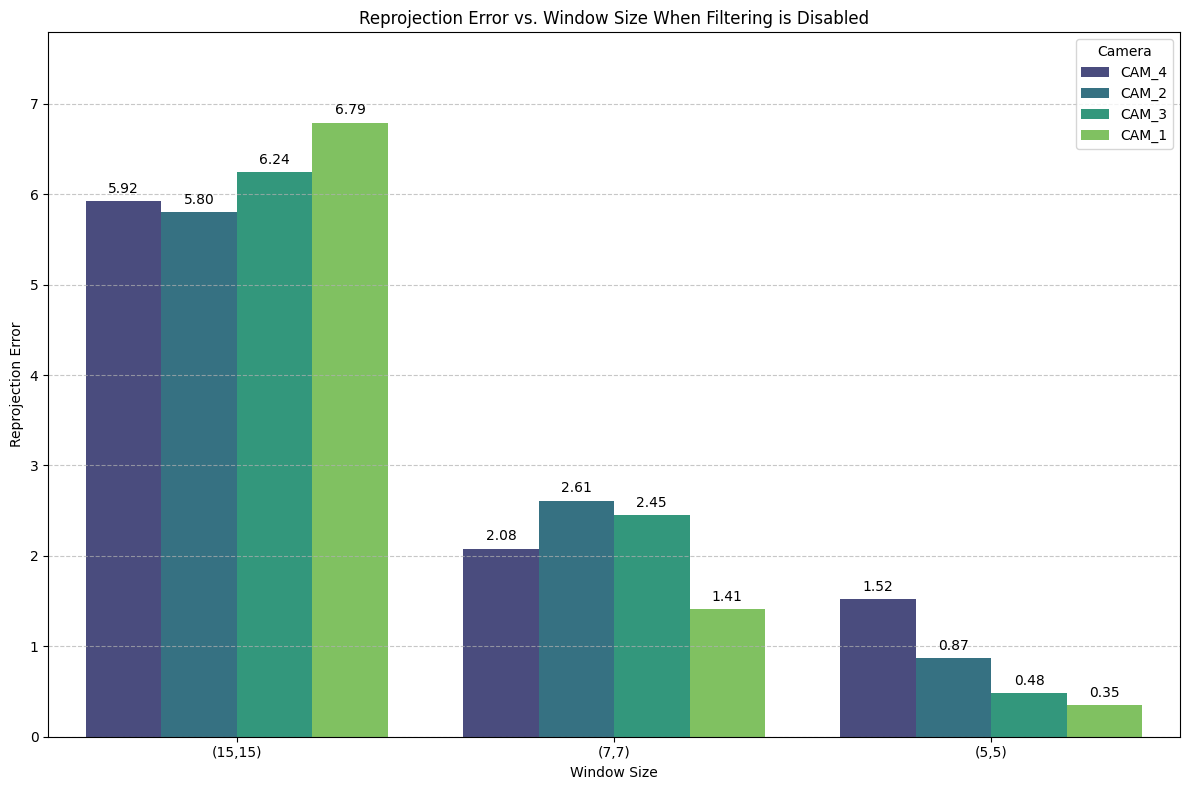

In [43]:
import seaborn as sns

# for threshold 0, plot how reprojection error decreases (lower values are better) as window size is lower

# Filter the data for threshold 0
df_threshold_0 = df[df['threshold'] == 0]

# Sort the data by reprojection error in descending order
df_threshold_0 = df_threshold_0.sort_values(by='error', ascending=False)

# Plot Reprojection Error vs. Window Size for Threshold 0
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='win_size', y='error', hue='camera', data=df_threshold_0, palette='viridis', order=[15, 7, 5])
plt.title('Reprojection Error vs. Window Size When Filtering is Disabled')
plt.xlabel('Window Size')
plt.ylabel('Reprojection Error')
plt.legend(title='Camera', loc='upper right')
plt.ylim(0, df_threshold_0['error'].max() + 1)  # Adjust y-axis limit for better readability
plt.xticks(ticks=[0, 1, 2], labels=["(15,15)", "(7,7)", "(5,5)"])  # Custom x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability

for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Skip annotation for zero values
        barplot.annotate(format(height, '.2f'),
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points')

plt.tight_layout()
plt.show()


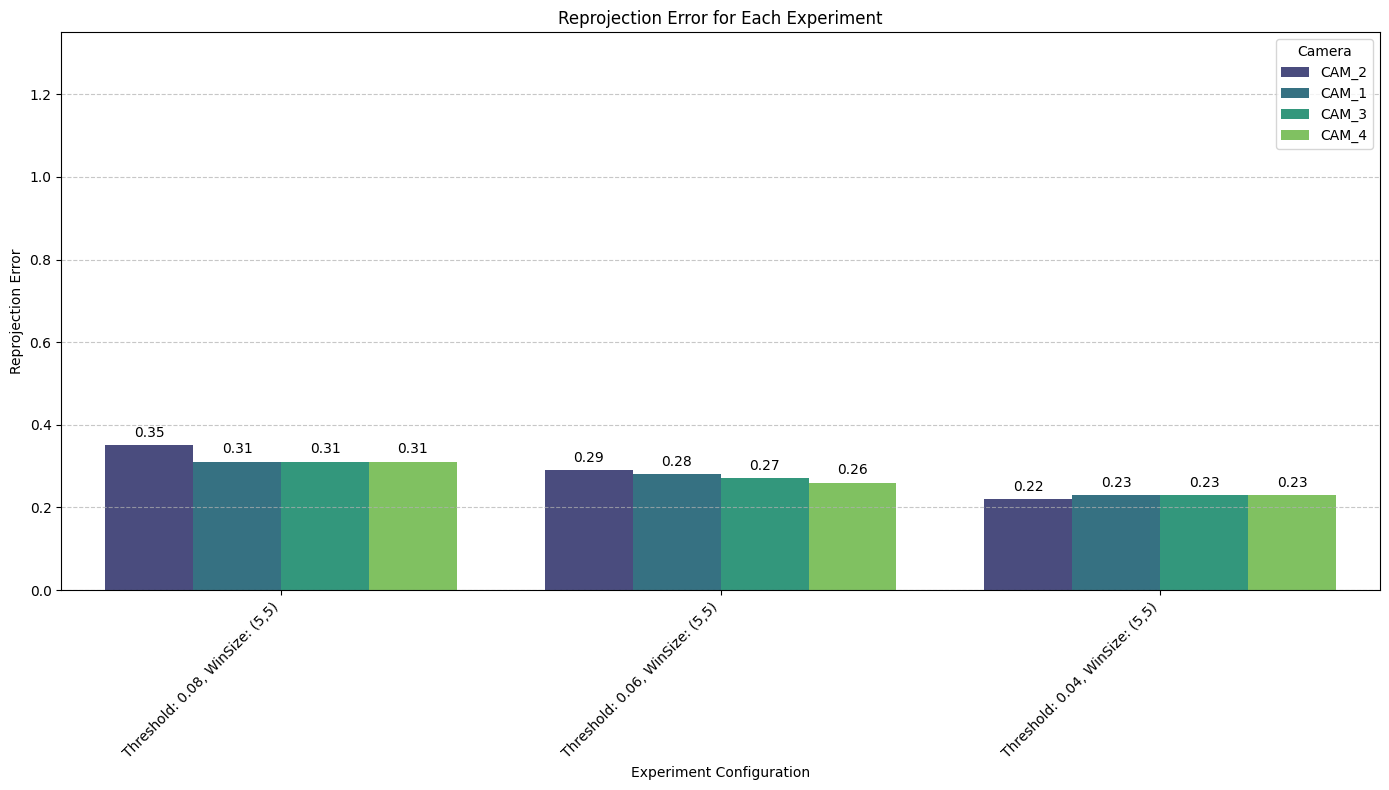

In [46]:
# Filter out experiments with window size 15
df = df[df['win_size'] != 15]
df = df[df['win_size'] != 7]
df = df[df['threshold'] != 0]

# Create a new column for experiment labels
df['experiment'] = df.apply(lambda row: f"Threshold: {row['threshold']}, WinSize: ({row['win_size']},{row['win_size']})", axis=1)

# Sort the data by reprojection error in descending order
df = df.sort_values(by='error', ascending=False)

# Plot Reprojection Error for Each Experiment
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='experiment', y='error', hue='camera', data=df, palette='viridis')
plt.title('Reprojection Error for Each Experiment')
plt.xlabel('Experiment Configuration')
plt.ylabel('Reprojection Error')
plt.legend(title='Camera', loc='upper right')
plt.ylim(0, df['error'].max() + 1)  # Adjust y-axis limit for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability

# Annotate the bars with the exact reprojection error values
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Skip annotation for zero values
        barplot.annotate(format(height, '.2f'),
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

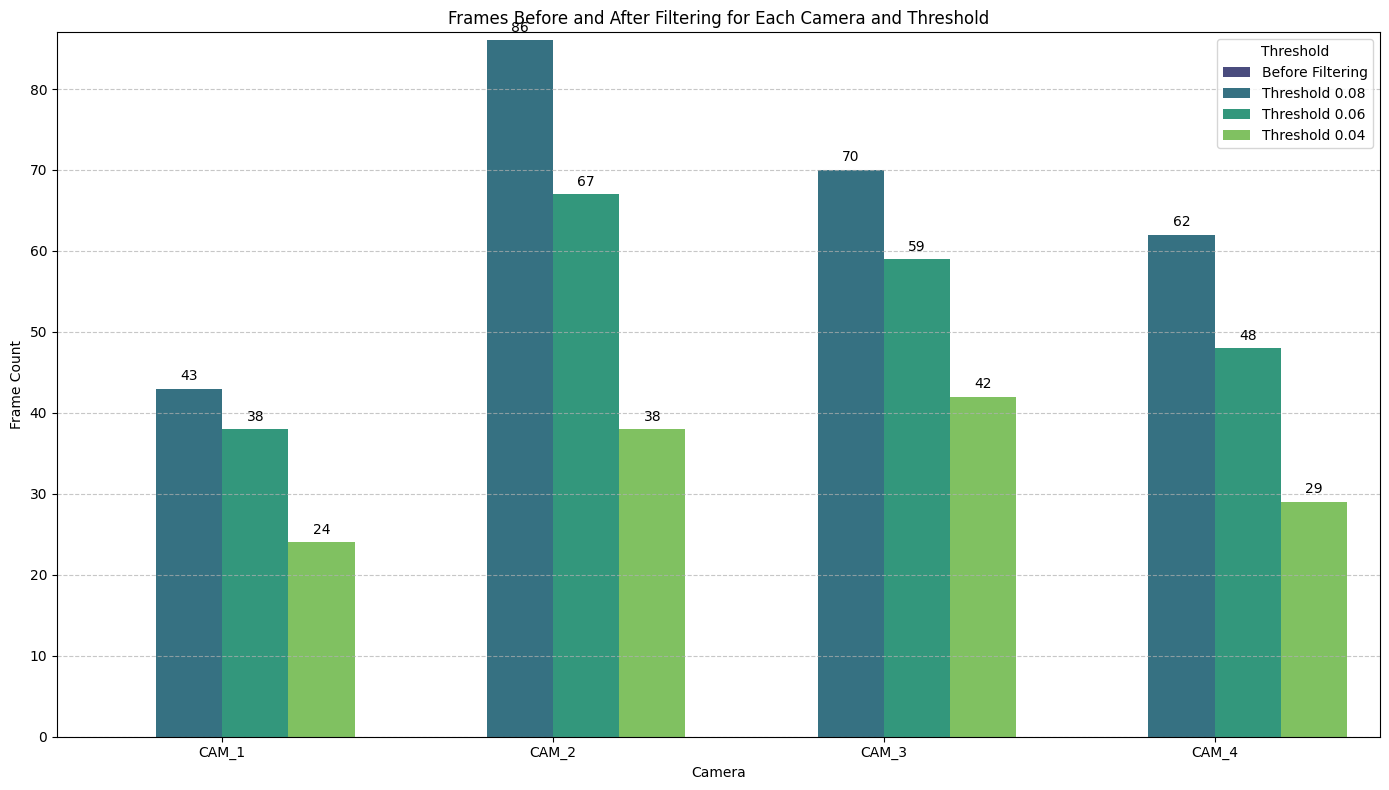

In [45]:
# Filter out threshold 0
df = df[df['threshold'] != 0]

# Create a new column for threshold labels
df['threshold_label'] = df['threshold'].apply(lambda x: f'Threshold {x}')

# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars=['camera', 'threshold_label'], value_vars=['frames_after'],
                    var_name='frame_type', value_name='frame_count')

# Add the 'frames_before' data
df_before = df[['camera', 'frames_before']].copy()
df_before['threshold_label'] = 'Before Filtering'
df_before['frame_type'] = 'frames_before'

# Concatenate the two DataFrames
df_combined = pd.concat([df_before, df_melted])

# Define the custom order of cameras
camera_order = ['CAM_1', 'CAM_2', 'CAM_3', 'CAM_4']  # Specify the desired order of cameras

# Plot Frames Before and After for Each Camera and Threshold
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='camera', y='frame_count', hue='threshold_label', data=df_combined, palette='viridis', errorbar=None,
                      estimator=sum, order=camera_order)
plt.title('Frames Before and After Filtering for Each Camera and Threshold')
plt.xlabel('Camera')
plt.ylabel('Frame Count')
plt.legend(title='Threshold', loc='upper right')
plt.ylim(0, df_combined['frame_count'].max() + 1)  # Adjust y-axis limit for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability

# Annotate the bars with the exact frame counts
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(format(height, '.0f'),
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         xytext=(0, 9),
                         textcoords='offset points')

plt.tight_layout()
plt.show()